In [1]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
print(len(train))
train.head()

891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
train['Sexn'] = train['Sex'].replace({'male': 0, 'female': 1})
test['Sexn'] = test['Sex'].replace({'male': 0, 'female': 1})

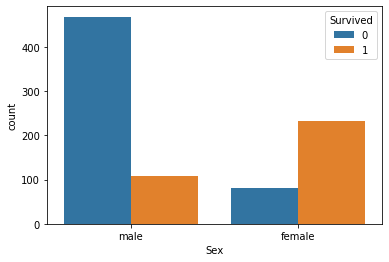

In [6]:
plt.subplots()
sns.countplot('Sex', hue='Survived', data=train)
plt.show()

In [7]:
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Master')), 10, inplace=True)
test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Master')), 10, inplace=True)

test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Miss')) & (test.Parch != 0), 10, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Miss')) & (train.Parch != 0), 10, inplace=True)

test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Miss')) & (test.Parch == 0), 25, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Miss')) & (train.Parch == 0), 25, inplace=True)

In [8]:
combined = pd.merge(train, test, how='outer')
ms_age = combined.loc[combined.Name.str.contains('Ms'), 'Age'].mean()
mrs_age = combined.loc[combined.Name.str.contains('Mrs'), 'Age'].mean()
mr_age = combined.loc[combined.Name.str.contains('Mr.'), 'Age'].mean()
dr_age = combined.loc[combined.Name.str.contains('Dr'), 'Age'].mean()

print(f'Avg age with title Ms: {ms_age}')
print(f'Avg age with title Mrs: {mrs_age}')
print(f'Avg age with title Mr: {mr_age}')
print(f'Avg age with title Dr: {dr_age}')

Avg age with title Ms: 28.0
Avg age with title Mrs: 36.804597701149426
Avg age with title Mr: 33.32208994708995
Avg age with title Dr: 36.5


In [9]:
test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Ms')), ms_age, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Ms')), ms_age, inplace=True)


test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Mrs')), mrs_age, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Mrs')), mrs_age, inplace=True)


test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Mr.')), mr_age, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Mr.')), mr_age, inplace=True)

test['Age'].mask((test.Age.isnull()) & (test.Name.str.contains('Dr')), dr_age, inplace=True)
train['Age'].mask((train.Age.isnull()) & (train.Name.str.contains('Dr')), dr_age, inplace=True)

In [10]:
train['Young'] = pd.cut(train.Age, 
                             bins = [0, 16, 100],
                             labels = [1, 0])

test['Young'] = pd.cut(test.Age, 
                             bins = [0, 16, 100],
                             labels = [1, 0])

In [11]:
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

In [12]:
train['Alone'] = 0
train.loc[train['Family'] == 1, 'Alone'] = 1

test['Alone'] = 0
test.loc[train['Family'] == 1, 'Alone'] = 1

train[['Alone', 'Survived']].groupby('Alone').mean()

,Survived
Alone,
0,0.505650
1,0.303538


In [13]:
pclass_3_avg_fare = combined.loc[(combined.Pclass == 3) & (combined.SibSp + combined.Parch == 0), 'Fare'].mean()
test['Fare'].mask(test.Name == 'Storey, Mr. Thomas', pclass_3_avg_fare, inplace=True)

In [14]:
train['Fare_PP'] = train['Fare'] / (train['Family'])
test['Fare_PP'] = test['Fare'] / (test['Family'])

In [15]:
train['Faregrp'] = pd.qcut(train['Fare_PP'], 3, 
                           labels=[0, 1, 2])

test['Faregrp'] = pd.qcut(test['Fare_PP'], 3, 
                           labels=[0, 1, 2])

train[['Faregrp', 'Survived']].groupby('Faregrp').mean()

,Survived
Faregrp,
0,0.289902
1,0.312500
2,0.579545


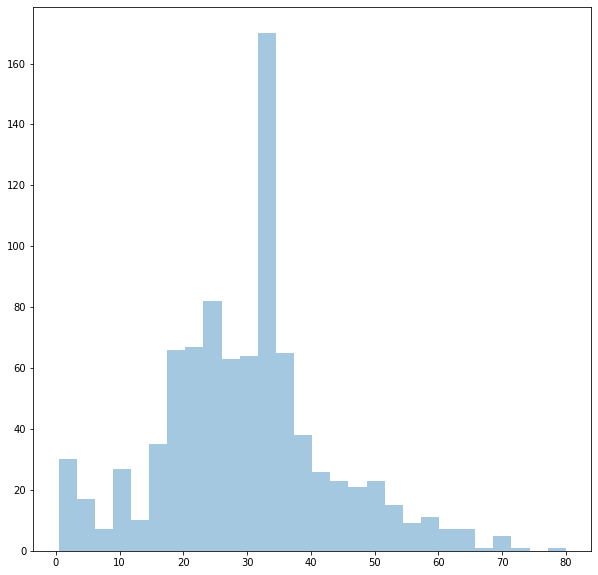

In [16]:
plt.figure(figsize=[10,10])
sns.distplot(train['Age'].values, kde=False)
plt.show()

In [17]:
train['Agegrp'] = pd.cut(train.Age, 
                             bins = [0, 16, 32, 48, 60, 80],
                             labels = [1, 2, 3, 4, 5])
test['Agegrp'] = pd.cut(test.Age, 
                        bins = [0, 16, 32, 48, 60, 80],
                        labels = [1, 2, 3, 4, 5])

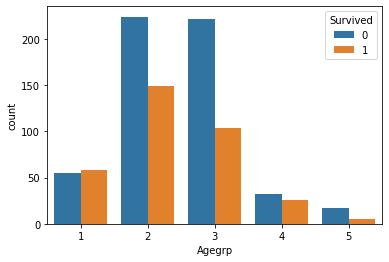

In [18]:
plt.subplots()
sns.countplot('Agegrp', hue='Survived', data=train)
plt.show()

In [19]:
train['Embarked'] = train['Embarked'].fillna('S')
train['Embarkedn'] = train['Embarked'].map({'S': 0, 
                                            'C': 1, 
                                            'Q': 2})

test['Embarkedn'] = test['Embarked'].map({'S': 0, 
                                          'C': 1, 
                                          'Q': 2})
train[['Embarkedn', 'Survived']].groupby('Embarkedn').mean()

,Survived
Embarkedn,
0,0.339009
1,0.553571
2,0.389610


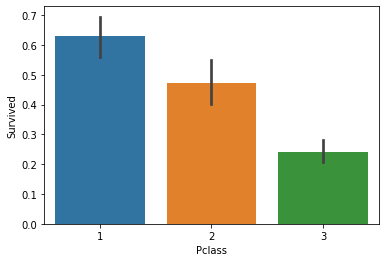

In [20]:
plt.subplots()
sns.barplot(x='Pclass', y='Survived', data=train)
plt.show()

In [21]:
train['Title'] = train['Name'].str.findall(r' (\w+)\.')
train['Title'] = train['Title'].str[0]

test['Title'] = test['Name'].str.findall(r' (\w+)\.')
test['Title'] = test['Title'].str[0]

print(train.Title.unique())
print(test.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [22]:
uncommon = ['Lady', 'Countess','Capt', 
            'Col','Don', 'Dr', 'Major', 
            'Rev', 'Sir', 'Jonkheer', 'Dona']

title_dictionary = {'Mr': 1, 'Mrs': 2, 'Miss': 3, 
                    'Master': 4, 'Uncommon': 5}

train['Title'] = train['Title'].replace(uncommon, 'Uncommon')
train['Title'] = train['Title'].replace(['Ms', 'Mlle'], 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
train['Title'] = train['Title'].map(title_dictionary)
train['Title'] = train['Title'].fillna(0)

test['Title'] = test['Title'].replace(uncommon, 'Uncommon')
test['Title'] = test['Title'].replace(['Ms', 'Mlle'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')
test['Title'] = test['Title'].map(title_dictionary)
test['Title'] = test['Title'].fillna(0)

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Sexn,Young,Family,Alone,Fare_PP,Faregrp,Agegrp,Embarkedn,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,0,2,0,3.62500,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,2,0,35.64165,2,3,1,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,1,0,1,1,7.92500,1,2,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,2,0,26.55000,2,3,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,1,1,8.05000,1,3,0,1


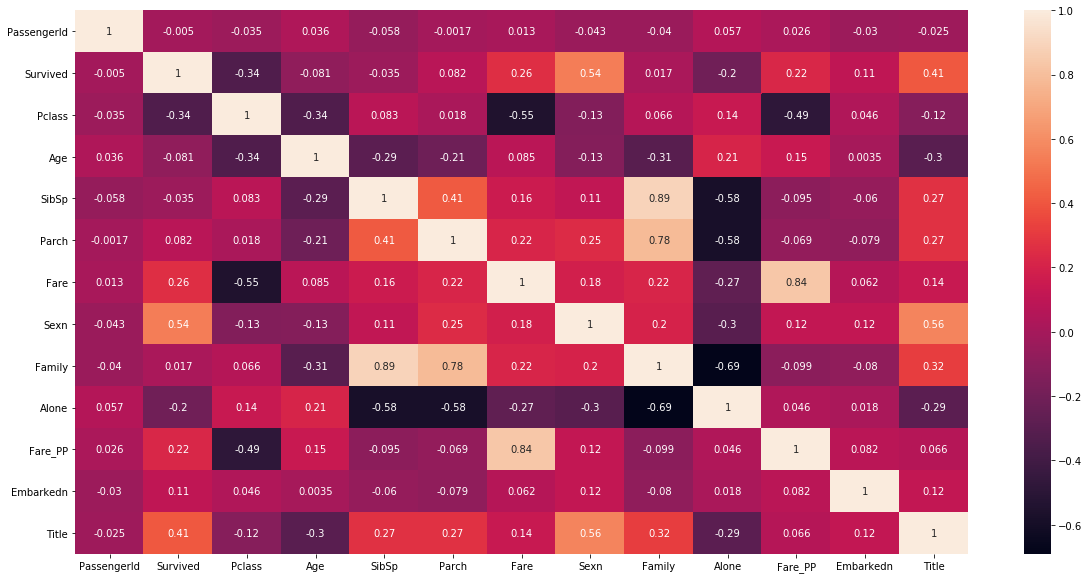

In [24]:
plt.figure(figsize=[20,10])
sns.heatmap(train.corr(),annot=True)
plt.show()

In [26]:
features_to_keep = ['Survived', 'Pclass', 'Sexn', 
                    'Agegrp', 'Family', 'Alone', 
                    'Faregrp', 'Embarkedn', 'Young','Title']
train_new = train[features_to_keep]

train_new.head()

,Survived,Pclass,Sexn,Agegrp,Family,Alone,Faregrp,Embarkedn,Young,Title
0,0,3,0,2,2,0,0,0,0,1
1,1,1,1,3,2,0,2,1,0,2
2,1,3,1,2,1,1,1,0,0,3
3,1,1,1,3,2,0,2,0,0,2
4,0,3,0,3,1,1,1,0,0,1


In [27]:
train_new.isnull().values.any()

False

In [28]:
features = ['Pclass', 'Sexn', 'Agegrp', 
            'Family', 'Alone', 'Faregrp', 
            'Embarkedn', 'Young', 'Title']
X_train, X_test, y_train, y_test = train_test_split(train_new[features], train_new['Survived'], test_size=0.25)

In [29]:
model = RandomForestClassifier().fit(X_train, y_train)

In [32]:
acc_score = model.score(X_train, y_train)

y_pred = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

roc_auc, acc_score

(0.7942590241247959, 0.8832335329341318)

In [33]:
scores = cross_val_score(model, X_train, y_train, 
                         cv=10, scoring='accuracy')

print('Scores:', scores)
print('Mean:', scores.mean())
print('Standard Deviation:', scores.std())

Scores: [0.86567164 0.85074627 0.7761194  0.7761194  0.85074627 0.74626866
 0.82089552 0.74626866 0.81818182 0.77272727]
Mean: 0.8023744911804614
Standard Deviation: 0.04222846595352908


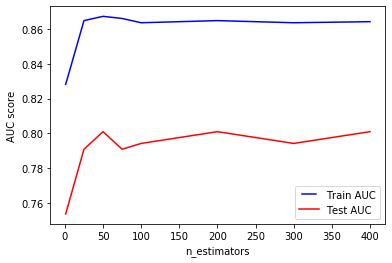

In [34]:
n_estimators = [1, 25, 50, 75, 100, 200, 300, 400]
train_results = []
test_results = []
for estimator in n_estimators:
   model = RandomForestClassifier(n_estimators=estimator)
   model.fit(X_train, y_train)
    
   train_pred = model.predict(X_train)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(X_test)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

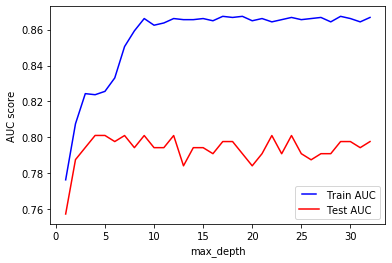

In [35]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   model = RandomForestClassifier(max_depth=max_depth)
   model.fit(X_train, y_train)
    
   train_pred = model.predict(X_train)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(X_test)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

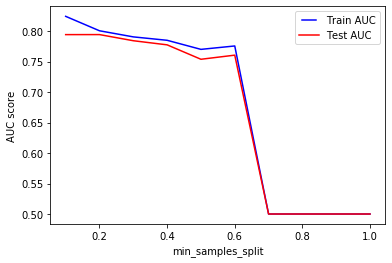

In [36]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   model = RandomForestClassifier(min_samples_split=min_samples_split)
   model.fit(X_train, y_train)
    
   train_pred = model.predict(X_train)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(X_test)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min_samples_split')
plt.show()

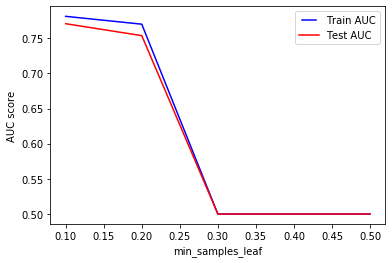

In [37]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   model.fit(X_train, y_train)
    
   train_pred = model.predict(X_train)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(X_test)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min_samples_leaf')
plt.show()

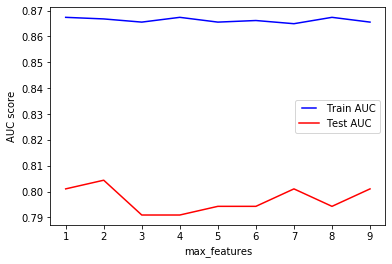

In [38]:
max_features = list(range(1,train_new.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   model = RandomForestClassifier(max_features=max_feature)
   model.fit(X_train, y_train)
    
   train_pred = model.predict(X_train)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(X_test)

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('max_features')
plt.show()

In [39]:
importances = pd.DataFrame({'feature':X_train.columns,
                            'importance': np.round(
                                model.feature_importances_,3)})
importances = importances.sort_values(
    'importance', ascending=False).set_index('feature')

importances

,importance
feature,
Title,0.387
Family,0.140
Pclass,0.138
Sexn,0.119
Agegrp,0.084
Embarkedn,0.054
Faregrp,0.048
Alone,0.018
Young,0.012


In [40]:
param_grid = {'n_estimators': [1, 25, 50, 75, 100, 200, 400],
              'max_depth': [1, 2, 3, 4, 5, 10, 15],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9], 
              'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

search = RandomizedSearchCV(model, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 75,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 2,
 'max_depth': 5}

In [41]:
model_final = RandomForestClassifier(
    n_estimators=200,
    max_features=5)
model_final.fit(train_new[features], train_new['Survived'])
test['Survived'] = model_final.predict(test[features])

In [42]:
scores = cross_val_score(model_final, X_train, y_train, 
                         cv=10, scoring='accuracy')

print('Scores:', scores)
print('Mean:', scores.mean())
print('Standard Deviation:', scores.std())

Scores: [0.85074627 0.85074627 0.80597015 0.79104478 0.86567164 0.76119403
 0.85074627 0.73134328 0.83333333 0.8030303 ]
Mean: 0.81438263229308
Standard Deviation: 0.04174385626584455


In [43]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Sexn,Young,Family,Alone,Fare_PP,Faregrp,Agegrp,Embarkedn,Title,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,1,0,7.829200,1,3,2,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,1,0,2,0,3.500000,0,3,0,2,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,1,1,9.687500,1,5,2,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,1,0,8.662500,1,2,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,1,0,3,1,4.095833,0,2,0,2,1


In [44]:
test[test.Sex.str.contains('female')]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Sexn,Young,Family,Alone,Fare_PP,Faregrp,Agegrp,Embarkedn,Title,Survived
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,1,0,2,0,3.500000,0,3,0,2,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,1,0,3,1,4.095833,0,2,0,2,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,...,1,0,1,1,7.629200,0,2,2,3,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,...,1,0,1,0,7.229200,0,2,1,2,1
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,...,1,0,2,1,41.133350,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1301,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,...,1,1,3,0,4.591667,0,1,0,3,1
410,1302,3,"Naughton, Miss. Hannah",female,25.0,0,0,365237,7.7500,NaN,...,1,0,1,1,7.750000,0,2,2,3,1
411,1303,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,...,1,0,2,1,45.000000,2,3,2,2,1
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,...,1,0,1,0,7.775000,0,2,0,3,0


In [45]:
test[test.Name.str.contains('Master')]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Sexn,Young,Family,Alone,Fare_PP,Faregrp,Agegrp,Embarkedn,Title,Survived
21,913,3,"Olsen, Master. Artur Karl",male,9.00,0,1,C 17368,3.1708,NaN,...,0,1,2,1,1.585400,0,1,0,4,1
55,947,3,"Rice, Master. Albert",male,10.00,4,1,382652,29.1250,NaN,...,0,1,6,1,4.854167,0,1,2,4,0
64,956,1,"Ryerson, Master. John Borie",male,13.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,...,0,1,5,1,52.475000,2,1,1,4,1
80,972,3,"Boulos, Master. Akar",male,6.00,1,1,2678,15.2458,NaN,...,0,1,3,1,5.081933,0,1,1,4,1
89,981,2,"Wells, Master. Ralph Lester",male,2.00,1,1,29103,23.0000,NaN,...,0,1,3,1,7.666667,0,1,0,4,1
154,1046,3,"Asplund, Master. Filip Oscar",male,13.00,4,2,347077,31.3875,NaN,...,0,1,7,1,4.483929,0,1,0,4,0
161,1053,3,"Touma, Master. Georges Youssef",male,7.00,1,1,2650,15.2458,NaN,...,0,1,3,1,5.081933,0,1,1,4,1
192,1084,3,"van Billiard, Master. Walter John",male,11.50,1,1,A/5. 851,14.5000,NaN,...,0,1,3,0,4.833333,0,1,0,4,1
194,1086,2,"Drew, Master. Marshall Brines",male,8.00,0,2,28220,32.5000,NaN,...,0,1,3,1,10.833333,1,1,0,4,1
196,1088,1,"Spedden, Master. Robert Douglas",male,6.00,0,2,16966,134.5000,E34,...,0,1,3,1,44.833333,2,1,1,4,1


In [46]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 
                       'Survived': test.Survived})
output.to_csv('titanic_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
